### Code reads stock values from csv file
* Location of input files is set in get_filename
* Location of output file is set in separate cell
* Run Main method to get all values for ticker listed in it
* Values changes are in  %
* ToDo: check if input file exists
* Modified functions to support two types of outputs: dataset1, dataset2; see comments below for details

In [1]:
# Dependencies
import csv
import os
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

### Subroutines

In [2]:
# Supporting functions
def get_filename(ticker):
    return os.path.join("..", "InputData", ticker + ".csv") # use relative location of the input files to the notebook

# Calculate relative change
def get_changepct(a, b):
    return 100 * (b - a) /  a  

In [3]:
weekdays = ['Mo', 'Tu', 'We', 'Th', 'Fr']

def read_ticker_file(file_name):
    # Input file into dataframe
    rawdata = pd.read_csv(file_name) 
    # Date into date type, date of week, week of year, Close value
    rawdata.Date = rawdata.Date.astype('datetime64[ns]')
    rawdata['Year.Week'] = [ td.year + (int(td.strftime("%W"))) / 100 for td in rawdata.Date] # YYYY.0W
    rawdata['Weekday'] = [ td.weekday() for td in rawdata.Date]
    rawdata['CloseValue'] = rawdata.Close # calculations use close values
    
    # Pivot data
    return rawdata.pivot(index='Year.Week', columns='Weekday', values='CloseValue')

def get_ticker_data(ticker):
    # Read data from input file, calculate changes between two days
    middata = read_ticker_file(get_filename(ticker))
    middata.columns = weekdays# change column names, pandas does not like numerical values (?)
    return middata

In [4]:
# Names for columns with calculated values
delta1 = 'Fr..Mo' 
delta2 = 'Tu..Th'

def get_dataset1(ticker):
    # This dataset has index, Ticker, and Th..Mo, Mo..Th delta values
    midset1 = get_ticker_data(ticker)
    
    # Replace NA values in the end of the week with previous non NA 
    #midset1 = midset1.fillna(method='ffill', axis=1)

    # Replace NA values at the beginning of the week with following non NA 
    #midset1 = midset1.fillna(method='bfill', axis=1)

    # New row with Thursday value from previous week, move the column values one row down
    midset1['Tmp'] = midset1.Th.shift(1)
    
    # Relative price change from previous week Thursday to this Monday per day
    midset1[delta1] = get_changepct(midset1.Tmp, midset1.Mo) / 2
    
    # Relative price change from this week Monday to this week Thursday per day
    midset1[delta2] = get_changepct(midset1.Mo, midset1.Th) / 3 

    # Drop temporaty column
    midset1 = midset1.drop('Tmp', axis=1)
    
    # Clean input data
    # Drop rows wiht NA values; run this before columns reduction
    cleanset1 = midset1.dropna()
    # Drop unused columns
    cleanset1 = cleanset1.loc[:, [delta1, delta2]]
 
    # Tiker into new column
    cleanset1.insert(loc=0, column='Ticker', value=ticker)

    return cleanset1

In [5]:
def get_dataset2(ticker):
    # This dataset has index, Ticker, and Th..Mo, Mo..Th delta values
    midset2 = get_ticker_data(ticker)

    # Replace NA values in the end of the week with previous non NA 
    midset2 = midset2.fillna(method='ffill', axis=1)

    # Replace NA values at the beginning of the week with following non NA 
    midset2 = midset2.fillna(method='bfill', axis=1)
    
    # Move the column values one row down, it's used for cross week change calculation
    midset2['Tmp'] = midset2.Fr.shift(1) 
    
    # Calculate relative value changes for each weekday
    midset2['Fr'] = get_changepct(midset2.Th, midset2.Fr)
    midset2['Th'] = get_changepct(midset2.We, midset2.Th)
    midset2['We'] = get_changepct(midset2.Tu, midset2.We)
    midset2['Tu'] = get_changepct(midset2.Mo, midset2.Tu)
    midset2['Mo'] = get_changepct(midset2.Tmp, midset2.Mo)

    # Drop temporaty column
    midset2 = midset2.drop('Tmp', axis=1) 
    
    # Clean input data
    cleanset2 = midset2.dropna() # drop rows wiht n/a values; run this before columns reduction 
    cleanset2.insert(loc=0, column='Ticker', value=ticker)
    cleanset2.insert(loc=1, column='Year', value=cleanset2.index)
    cleanset2.Year = cleanset2.Year.astype(int) # get year number by column data type change
    return cleanset2

In [6]:
tickers = ["XLB","XLC","XLE","XLF","XLI","XLK","XLP","XLRE","XLU","XLV","XLY"]

# Main method, call it to extract data from input file into DataFrame
def main(setnr):
    # List of tickers
    outputdf = pd.DataFrame()

    print(f"Running data extraction {setnr} ...")
    print("Ticker: ", end = '')
    for ticker in tickers:
        if(setnr == 1):
            outputdf = outputdf.append(get_dataset1(ticker))
        elif(setnr == 2):
            outputdf = outputdf.append(get_dataset2(ticker))
        else:
            continue
        print(ticker, end = ' ')
    print("")
    print("... done.")

    return outputdf

### Dataset 2

In [7]:
# Run data extraction
# Returned value is df, you can save its value into file, or use it otherwise
dataout2 = main(2)
dataout2.head()

Running data extraction 2 ...
Ticker: 

C:\Users\Joshi_Pavilion\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


XLB XLC XLE XLF XLI XLK XLP XLRE XLU XLV XLY 
... done.


,Ticker,Year,Mo,Tu,We,Th,Fr
Year.Week,,,,,,,
2000.02,XLB,2000,-0.341448,-1.199336,-1.445109,0.410580,-0.700935
2000.03,XLB,2000,-2.411742,0.000000,-1.928872,-2.642924,0.441943
2000.04,XLB,2000,-2.639897,-1.872151,0.000000,0.526316,-1.701571
2000.05,XLB,2000,-0.599227,1.808466,0.460552,-1.702735,-0.133193
2000.06,XLB,2000,-1.934648,-0.272109,-1.978198,-0.835073,-2.456114


In [8]:
# Check basic stat
dataout2.describe()

,Year,Mo,Tu,We,Th,Fr
count,9507.000000,9507.000000,9507.000000,9507.000000,9507.000000,9507.000000
mean,2009.508467,0.008888,0.072679,0.037668,0.044975,-0.034612
std,5.723998,1.520621,1.328547,1.414532,1.391195,1.249656
min,2000.000000,-16.666670,-10.561794,-14.443789,-14.396521,-8.115132
25%,2005.000000,-0.588363,-0.465719,-0.589092,-0.526921,-0.584804
50%,2010.000000,0.061652,0.000000,0.035211,0.042772,0.000000
75%,2015.000000,0.685190,0.607615,0.671833,0.682195,0.593503
max,2019.000000,16.474647,15.705618,16.101695,15.543491,11.844084


In [9]:
# Data into output file
outfile = os.path.join("..", "OutputData", "TickersDataSet2.csv")
dataout2.to_csv(outfile)

In [10]:
# Number of days with best return per week
dataout2['MaxDay'] = dataout2[weekdays].idxmax(axis=1, skipna=True)
dataout2['MaxDay'].value_counts()

Mo    2139
We    1941
Th    1935
Tu    1888
Fr    1604
Name: MaxDay, dtype: int64

In [11]:
dataout2[weekdays].sum()

Mo     84.500535
Tu    690.956984
We    358.109388
Th    427.581980
Fr   -329.054936
dtype: float64

### Dataset 1

In [12]:
# Get dataset1
dataout1 = main(1)
dataout1.head()

Running data extraction 1 ...
Ticker: XLB XLC XLE XLF XLI XLK XLP XLRE XLU XLV XLY 
... done.


,Ticker,Fr..Mo,Tu..Th
Year.Week,,,
2000.02,XLB,-0.199079,-0.742440
2000.04,XLB,-1.104810,-0.451896
2000.05,XLB,-1.145301,0.178611
2000.06,XLB,-1.032632,-1.020417
2000.07,XLB,-0.421053,0.566171


In [13]:
# Check basic stat
print(dataout1.describe())
delta1sum = dataout1[delta1].sum()
delta2sum = dataout1[delta2].sum()
print(f"Σ{delta1}: {round(delta1sum * 2,2)}%  Σ{delta2}: {round(delta2sum * 3,2)}%")

            Fr..Mo       Tu..Th
count  7534.000000  7534.000000
mean     -0.016336     0.047974
std       0.981911     0.809931
min      -7.117182    -7.696630
25%      -0.441224    -0.341914
50%       0.043619     0.062598
75%       0.470824     0.449077
max       9.459462    10.010644
ΣFr..Mo: -246.15%  ΣTu..Th: 1084.3%


In [14]:
# T-Test - ticker sum
ttest_ind(dataout1[delta1], dataout1[delta2])

Ttest_indResult(statistic=-4.385446298362287, pvalue=1.165331566471324e-05)

In [15]:
# T-Test - individual tickers
for ticker in tickers:
    df = dataout1[dataout1['Ticker'] == ticker]
    print(f"{ticker} ({len(df)}x): {ttest_ind(df[delta2], df[delta1])}")

XLB (815x): Ttest_indResult(statistic=1.5585663985947462, pvalue=0.11929340361415564)
XLC (43x): Ttest_indResult(statistic=1.2818825008559331, pvalue=0.20341071930823088)
XLE (815x): Ttest_indResult(statistic=1.2444510838507101, pvalue=0.21351271711331013)
XLF (815x): Ttest_indResult(statistic=1.178466234567816, pvalue=0.23878300333397945)
XLI (815x): Ttest_indResult(statistic=1.657142976172875, pvalue=0.09768325037867653)
XLK (815x): Ttest_indResult(statistic=2.1584930494199055, pvalue=0.031035285290462872)
XLP (815x): Ttest_indResult(statistic=1.3970973042589285, pvalue=0.16257470104206997)
XLRE (156x): Ttest_indResult(statistic=-0.4406576039765521, pvalue=0.6597680199264176)
XLU (815x): Ttest_indResult(statistic=-0.7988427595447396, pvalue=0.4244981161496798)
XLV (815x): Ttest_indResult(statistic=2.678530853994771, pvalue=0.00746899958945136)
XLY (815x): Ttest_indResult(statistic=2.1579151527660483, pvalue=0.03108027458213101)


In [16]:
# Data into output file
outfile = os.path.join("..", "OutputData", "TickersDataSet1.csv")
dataout1.to_csv(outfile)

### Charts

In [17]:
# Check data shape - skewness
# higly skwed +/-1; moderately skewed +/-0.5; almost symetric   
dataout1.skew(axis = 0, skipna = True)

Fr..Mo   -0.325759
Tu..Th    0.166343
dtype: float64

In [18]:
# Check data shape - kurtosis
# heavy tail > 3( Normal Distribution) > light tail  
dataout1.kurt(axis = 0, skipna = True)

Fr..Mo     7.015168
Tu..Th    11.133892
dtype: float64

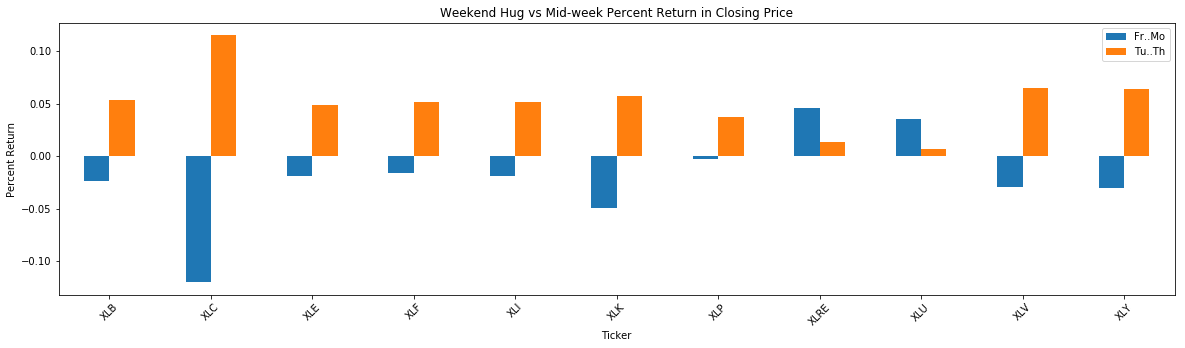

<Figure size 432x288 with 0 Axes>

In [19]:
    dataout3= dataout1.groupby("Ticker")
    dataout3_df=dataout3.mean()
    ticker_plot= dataout3_df.plot(kind="bar", figsize=(20,5))
    ticker_plot.set_xticklabels(dataout3_df.index, rotation=45)
    ticker_plot.set_ylabel("Percent Return")
    plt.title("Weekend Hug vs Mid-week Percent Return in Closing Price")
    plt.show()
    plt.tight_layout()

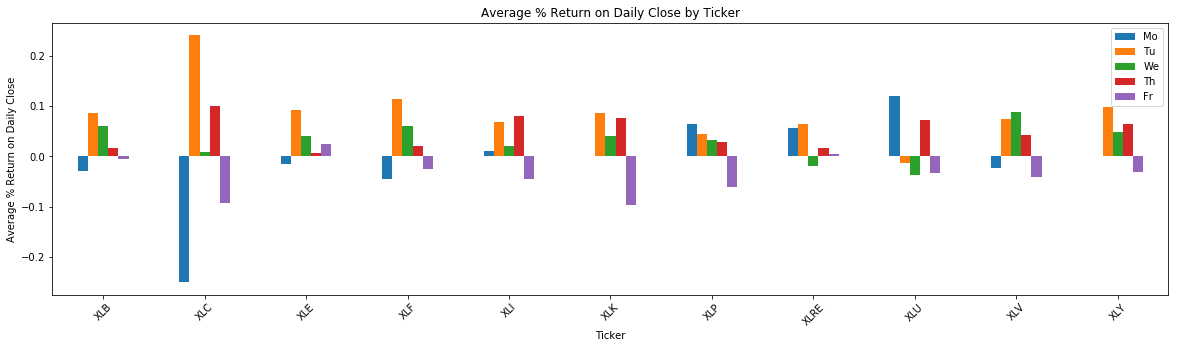

<Figure size 432x288 with 0 Axes>

In [20]:
    dataout4= dataout2.groupby("Ticker")
    dataout4_df=dataout4.mean()
    dataout4_df.head()
    dataout5_df= dataout4_df.drop(columns="Year")
    ticker_plot= dataout5_df.plot(kind="bar", figsize=(20,5))
    ticker_plot.set_xticklabels(dataout5_df.index, rotation=45)
    ticker_plot.set_ylabel("Average % Return on Daily Close")
    plt.title("Average % Return on Daily Close by Ticker")
    plt.show()
    plt.tight_layout()
   

In [21]:
    total6=pd.DataFrame(dataout1.mean())

In [22]:
rows1=total6.iloc[0:3]

In [23]:
rows1

,0
Fr..Mo,-0.016336
Tu..Th,0.047974


In [24]:
rows1T=rows1.T

In [25]:
rows1T

,Fr..Mo,Tu..Th
0,-0.016336,0.047974


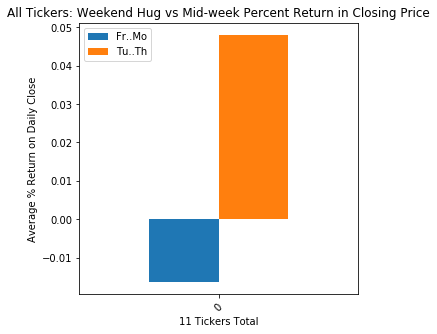

<Figure size 432x288 with 0 Axes>

In [26]:
    total_plot= rows1T.plot(kind="bar", figsize=(5,5))
    total_plot.set_xticklabels(rows1T.index, rotation=45)
    total_plot.set_ylabel("Average % Return on Daily Close")
    total_plot.set_xlabel("11 Tickers Total")
    plt.title("All Tickers: Weekend Hug vs Mid-week Percent Return in Closing Price")
    plt.show()
    plt.tight_layout()